# Univariate Linear Regression

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

### Let's Start With The Math!

##### Univariate linear regression function
$$f_{w,b}(x)=wx+b$$

In [2]:
def lin_reg_func(x, w, b):
    """Linear regression function.

        Parameters:
            x (ndarray): vector of m feature values
            w (float): weight parameter
            b (float): bias parameter

        Returns:
            ndarray: output of linear regression function for each feature value in x
    """
    return (w * x) + b

##### Cost function: Mean Squared Error (MSE)
$$J(w,b)=\frac{1}{2m}\sum_{i=1}^m(f_{w,b}(x^{(i)})-y^{(i)})^2$$

In [3]:
def compute_cost(y_hat, y):
    """Mean squared error (MSE) cost function.

        Parameters:
            y_hat (ndarray): vector of m predictions
            y (ndarray): vector of m target values

        Returns:
            float: output of MSE cost function
    """
    m = len(y_hat)
    return (1 / (2 * m)) * np.sum((y_hat - y)**2)
    

##### Gradients
$$\frac{\partial}{\partial w}J(w,b)=\frac{1}{m}\sum_{i=1}^m(f_{w,b}(x^{(i)})-y^{(i)})x^{(i)}$$
$$\frac{\partial}{\partial b}J(w,b)=\frac{1}{m}\sum_{i=1}^m(f_{w,b}(x^{(i)})-y^{(i)})$$

In [4]:
def compute_gradients(x, y, y_hat):
    """Gradients, or derivate of cost function with respect to each parameter.

        Parameters:
            x (ndarray): vector of m feature values
            y (ndarray): vector of m target values
            y_hat (ndarray): vector of m predictions

        Returns:
            tuple containing

            - float: gradient with respect to w
            - float: gradient with respect to b
    """
    m = len(x)
    dj_dw = (1 / m) * np.sum((y_hat - y) * x)
    dj_db = (1 / m) * np.sum(y_hat - y)
    return dj_dw, dj_db

##### Gradient descent updates
$$w=w-\alpha\frac{\partial}{\partial w}J(w,b)$$
$$b=b-\alpha\frac{\partial}{\partial b}J(w,b)$$

In [5]:
def update_param(param, alpha, gradient):
    """Update parameter step.

        Parameters:
            param (float): learnable parameter to update
            alpha (float): learning rate
            gradient (float): gradient with respect to parameter

        Returns:
            param (float): learnable parameter after update
    """
    param -= alpha * gradient
    return param

### California Housing Dataset

In [6]:
housing_dataset = datasets.fetch_california_housing()
X = housing_dataset['data']
y = housing_dataset['target']
print(housing_dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

### Pearson Correlation Coefficient

We're only doing *univariate* linear regression, so let's find the feature that most correlates with the target variable (median house value).

$$r=\frac{\sum_{i=1}^m((x^{(i)}-\bar{x})(y^{(i)}-\bar{y}))}{\sqrt{\sum_{i=1}^m(x^{(i)}-\bar{x})^2\sum_{i=1}^m(y^{(i)}-\bar{y})^2}}$$

In [7]:
def compute_corr(x, y):
    """Compute Pearson correlation coefficient.

        Parameters:
            x (ndarray): vector of m feature values
            y (ndarray): vector of m target values

        Returns:
            float: Pearson correlation coefficient
    """
    x_bar = np.mean(x)
    y_bar = np.mean(y)

    numerator = np.sum((x - x_bar) * (y - y_bar))
    denominator = (np.sum((x - x_bar)**2) * np.sum((y - y_bar)**2))**0.5
    return numerator / denominator

In [8]:
corr_dict = {'feature': [], 'corr': []}

for feature_idx in range(len(housing_dataset['feature_names'])):
    corr_dict['feature'].append(housing_dataset['feature_names'][feature_idx])
    corr_dict['corr'].append(compute_corr(X[:, feature_idx], y))

corr_df = pd.DataFrame(corr_dict)
corr_df.sort_values('corr', ascending=False)

,feature,corr
0,MedInc,0.688075
2,AveRooms,0.151948
1,HouseAge,0.105623
5,AveOccup,-0.023737
4,Population,-0.024650
7,Longitude,-0.045967
3,AveBedrms,-0.046701
6,Latitude,-0.144160


Since the Pearson correlation coefficient for feature "MedInc" (at index 0) is the furthest from 0.0, it has the best correlation with the target variable and will be our sole predictor in our univariate linear regression model.

In [9]:
x = X[:, 0]     # Only get "MedInc" column

### Visualize And Clean Dataset

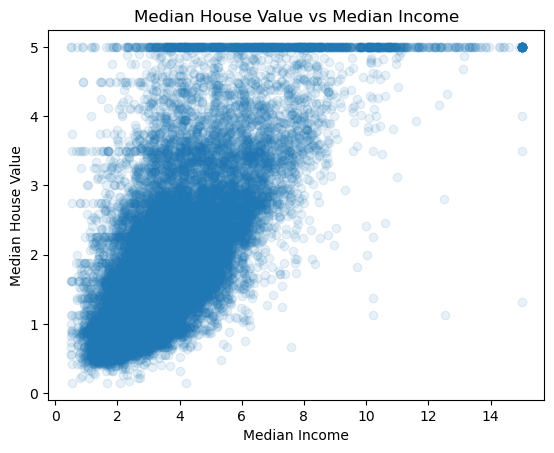

In [10]:
plt.scatter(x, y, alpha=0.1)
plt.title('Median House Value vs Median Income')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

There seems to be some horizontal lines within the data, including the obvious cap at about y = 5.0. Let's clean up the data a bit by removing these overly frequent data points.

In [11]:
# Get list of y values that appear at least 25 times in the dataset
y_values, counts = np.unique(y, return_counts=True)
y_frequent_values = y_values[np.where(counts >= 25)]

# Remove all data points at each of the frequent y values
x_clean = np.delete(x, np.where(np.isin(y, y_frequent_values)))
y_clean = np.delete(y, np.where(np.isin(y, y_frequent_values)))

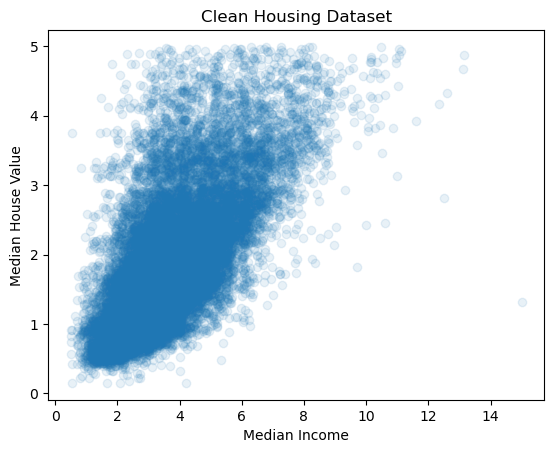

In [12]:
plt.scatter(x_clean, y_clean, alpha=0.1)
plt.title('Clean Housing Dataset')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

### Split Dataset Into Training/Test Sets

In [13]:
def train_test_split(x, y, test_proportion=0.2):
    """Splits dataset into training set and test set.

        Parameters:
            x (ndarray): vector of m feature values
            y (ndarray): vector of m target values
            test_proportion (float): proportion of dataset to set to test set (default to 0.2)

        Returns:
            tuple containing

            - ndarray: vector of (m * 0.8) training set feature values
            - ndarray: vector of (m * 0.8) training set target values
            - ndarray: vector of (m * 0.2) test set feature values
            - ndarray: vector of (m * 0.2) test set target values
    """
    random_indices = np.random.permutation(len(x))
    test_size = round(test_proportion * len(x))
    test_indices = random_indices[:test_size]
    train_indices = random_indices[test_size:]

    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]

    return x_train, y_train, x_test, y_test    

In [14]:
x_train, y_train, x_test, y_test = train_test_split(x_clean, y_clean)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (14395,)
y_train shape: (14395,)


### Training

First we set the *hyperparameters* to configure our training process, and then we train on the training set.

In [15]:
def gradient_descent(x, y, w, b, alpha, num_epochs):
    """Gradient descent training process.
    
        Parameters:
            x (ndarray): vector of m training set feature values
            y (ndarray): vector of m training set target values
            w (float): initial weight parameter value
            b (float): initial bias parameter value
            alpha (float): learning rate
            num_epochs (int): number of epochs to execute

        Returns:
            tuple containing

            - float: learned weight parameter
            - float: learned bias parameter
            - list[float]: log of costs after each epoch
    """
    cost_log = []

    for epoch in range(num_epochs):
        # Predict
        y_hat = lin_reg_func(x, w, b)

        # Compute Cost
        cost = compute_cost(y_hat, y)
        cost_log.append(cost)

        # Train
        dj_dw, dj_db = compute_gradients(x, y, y_hat)
        w = update_param(w, alpha, dj_dw)
        b = update_param(b, alpha, dj_db)

        print(f'Epoch: {epoch + 1} | Cost: {cost}')
    
    return w, b, cost_log


In [16]:
w, b, cost_log = gradient_descent(
    x_train, y_train,
    w=0.0, b=0.0,
    alpha=0.0005,
    num_epochs=500)

Epoch: 1 | Cost: 2.3526129745745155
Epoch: 2 | Cost: 2.316488741870383
Epoch: 3 | Cost: 2.2809898707317555
Epoch: 4 | Cost: 2.2461055350816497
Epoch: 5 | Cost: 2.2118250962609927
Epoch: 6 | Cost: 2.178138099784101
Epoch: 7 | Cost: 2.145034272150322
Epoch: 8 | Cost: 2.112503517710873
Epoch: 9 | Cost: 2.080535915589922
Epoch: 10 | Cost: 2.0491217166589686
Epoch: 11 | Cost: 2.018251340563605
Epoch: 12 | Cost: 1.987915372801746
Epoch: 13 | Cost: 1.9581045618524426
Epoch: 14 | Cost: 1.9288098163543992
Epoch: 15 | Cost: 1.900022202333337
Epoch: 16 | Cost: 1.8717329404773537
Epoch: 17 | Cost: 1.843933403459456
Epoch: 18 | Cost: 1.8166151133064379
Epoch: 19 | Cost: 1.789769738813312
Epoch: 20 | Cost: 1.7633890930025025
Epoch: 21 | Cost: 1.737465130627019
Epoch: 22 | Cost: 1.71198994571686
Epoch: 23 | Cost: 1.686955769167888
Epoch: 24 | Cost: 1.6623549663724495
Epoch: 25 | Cost: 1.6381800348910087
Epoch: 26 | Cost: 1.6144236021640925
Epoch: 27 | Cost: 1.591078423263844
Epoch: 28 | Cost: 1.56813

### Assess Results

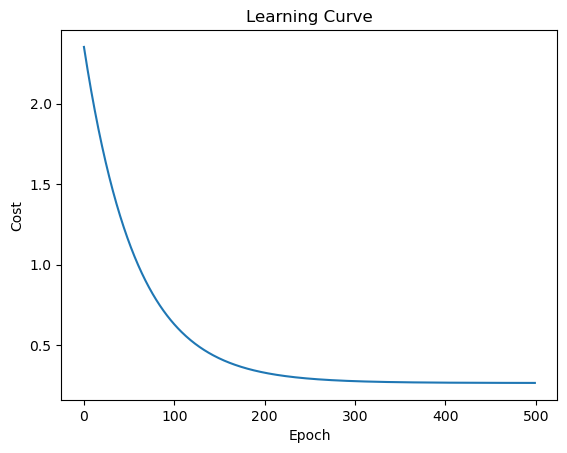

In [17]:
plt.plot(cost_log)
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [18]:
y_hat = lin_reg_func(x_test, w, b)
test_cost = compute_cost(y_hat, y_test)

print(f'Cost on training set: {cost_log[-1]}')
print(f'Cost on test set: {test_cost}')

Cost on training set: 0.2659979558703122
Cost on test set: 0.2657877828113094


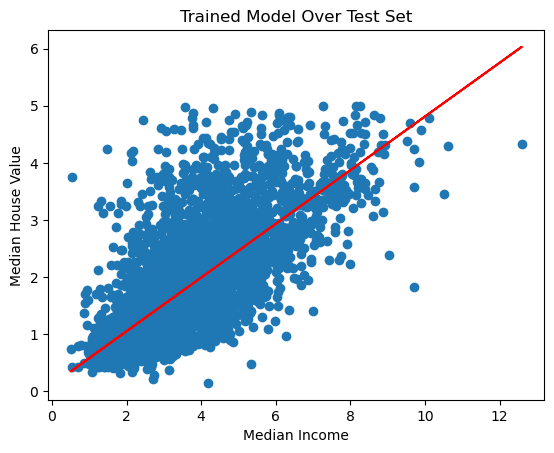

In [19]:
plt.scatter(x_test, y_test)
plt.plot(x_test, (w * x_test) + b, c='red')
plt.title('Trained Model Over Test Set')
plt.xlabel('Median Income')
plt.ylabel('Median House Value')
plt.show()

Overall, not bad, but we can do better with more features...